# **Курсовая работа по дисциплине "Автоматика и регулирование ЖРД"**

## Исходные данные

In [1]:
from scipy.integrate import odeint
import numpy as np
from numpy import pi, sin
import pandas as pd
from icecream import ic

p1 = 400e3
p1_0=400e3
p2 = 300e3
p2_0 = 300e3
p3 = 100e3
p4_0 = 289442.719

k = 1.4
R = 297
p0_gas = 1.2506

c = 1200

Vд_0 = 0

mд_0 = 0
m1_0 = 10.515
m2_0 = 3.249
m3_0 = 13.764

Vж0 = 0.004
ρж = 820

Tгаз0 = 293
ρг = p4_0 / (R * Tгаз0)
Vг0 = 0.003
mгаз = ρг * Vг0

j1 = 400
j2 = 400
j3 = 400
# jд = 1000
jд = 20

ξ1 = 1000
ξ3 = 1000
ξ2 = 1000
ξд = 1000

## Решение стационарной задачи

In [2]:
from scipy.optimize import fsolve
import numpy as np
import random
import warnings as w

w.filterwarnings("ignore")


# Определяем функцию для fsolve
def equations(vars):
    m1_0, m2_0, m3_0, p4_0, pgas_0 = vars
    
    return [m1_0 + m2_0 - m3_0,
            p4_0 - pgas_0,
            p1_0 - p4_0 - ξ1*m1_0**2,
            p4_0 - p3 - ξ3*m3_0**2,
            p2 - p4_0 - ξ2*m2_0**2]


# Вводим случайные приближения
initial_guess = [random.random() for _ in range(5)]

# Пока корни меньше нуля менять случайные приближения
while min(fsolve(equations, initial_guess)) <= 0:
    initial_guess = [random.random() for _ in range(5)]
  
solution = fsolve(equations, initial_guess)

# Вывод решения
# print("Solution:", solution)

m1_0 = solution[0]
m2_0 = solution[1]
m3_0 = solution[2]
p4_0 = solution[3]
pgas_0 = solution[4]

# Вывод переменных
print("  m1_0 = {:.3f}".format(m1_0))
print("  m2_0 = {:.3f}".format(m2_0))
print("  m3_0 = {:.3f}".format(m3_0))
print("  p4_0 = {:.3f}".format(p4_0))
print("pgas_0 = {:.3f}".format(pgas_0))

  m1_0 = 10.515
  m2_0 = 3.249
  m3_0 = 13.764
  p4_0 = 289442.719
pgas_0 = 289442.719


## Решение динамической задачи с демпфером

### Система уравнений

$$
\begin{cases}
\begin{align}
\frac{{d}}{{dt}}{p}_{4} &=\frac{\left(m_{1}+{m}_{2}-{m}_{3}-{m}_{\text{д}}\right)}{\frac{{V}_{\text{ж}0^{+}}{V}_{\text{д}}}{{c}^{2}}} \\

\frac{{d}}{{dt}}{V}_{д} &=\frac{m_{д}}{\rho_{ж}} \\

\frac{d}{dt}m_{д} &=\frac{\left[p_{4}-\frac{m_{газ}}{V_{г0}-V_{д}} \cdot R \cdot \left[T_{газ0} \cdot \left(\frac{p_{4}}{p_{4,0}}\right)^{\frac{k-1}{k}}\right]-\xi_{д} \cdot m_{д} \cdot \left|m_{д}\right|\right]}{j_{д}} \\

\frac{{d}}{{dt}}m_1 &=\frac{\left({p}_1-{p}_4-{\xi}_1\cdot{m}_1^2\right)}{{j}_1} \\

{\frac{d}{dt}}m_{2} &={\frac{\left(p_{2}-p_{4}-\xi_{2}\cdot m_{2}^{2}\right)}{j_{2}}} \\

\frac{d}{dt}m_{3} &=\frac{\left({p}_{4}-{p}_{3}-{\xi}_{3}\cdot{m}_{3}^{2}\right)}{{j}_{3}}
\end{align}
\end{cases}
$$

### Функция возмущения

$$
\mathrm{p2(t)}=\left[
    \begin{matrix}
    A\sin\left(z(t)-\frac{\pi}{2}\right)+A+x_0 \quad &\text{если}\quad &0\leq t \leq T, \\
    x_0 \quad &\text{если}\quad &t\ >\ T 
    \end{matrix}
\right.
$$
где
$$
z(t) = 2 \cdot t \cdot \frac{\pi}{T}
$$

### Решение методом  `LSODA`

#### Решение СДУ

In [24]:
def system(y, t, func_p2):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (func_p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * 
            (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


def p2(t):
    """ Функция возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


def p2_sin(t):
    """ Функция возмущения """
    z = 2 * t * pi/T
    insin = z - pi/2
    p2 = p2_0 + A*sin(insin)
    return p2


A = 1000
T = 0.1

t_end = .8
h = 1e-6

y0 = [p4_0, Vд_0, m1_0, m2_0, m3_0, mд_0]
t = np.arange(0, t_end, h)

# Решение
sol = odeint(system, y0, t, (p2,))

# Вывод таблицы значений
# ic(pd.DataFrame(data=sol, index=t))

pгаз = (mгаз / (Vг0 - sol[:, 1])) * R * \
    (Tгаз0 * ((sol[:, 0] / p4_0)**((k-1)/k)))

In [32]:
max(sol[:, 0])

290167.6953142216

#### Построение графиков

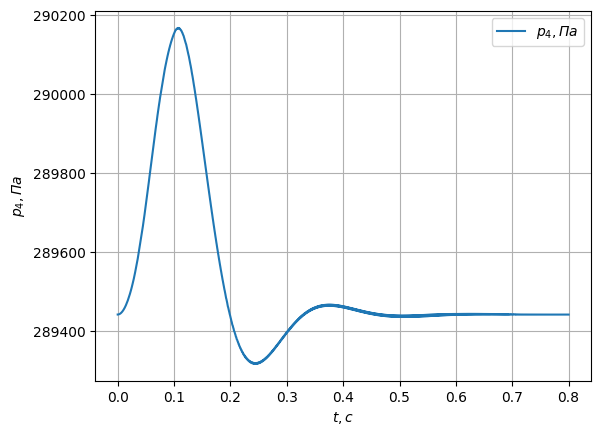

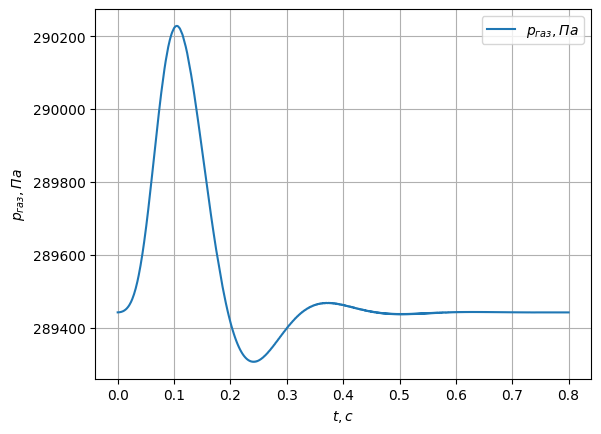

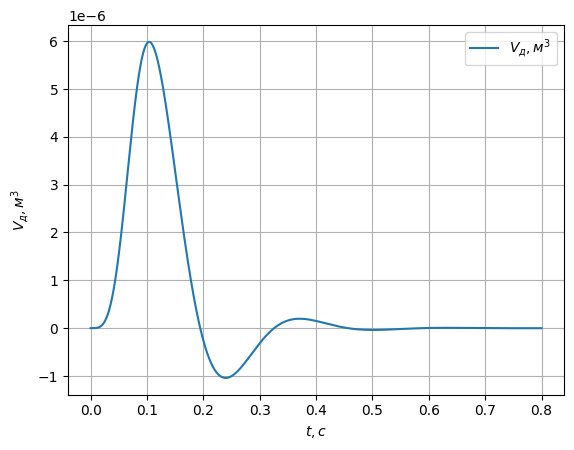

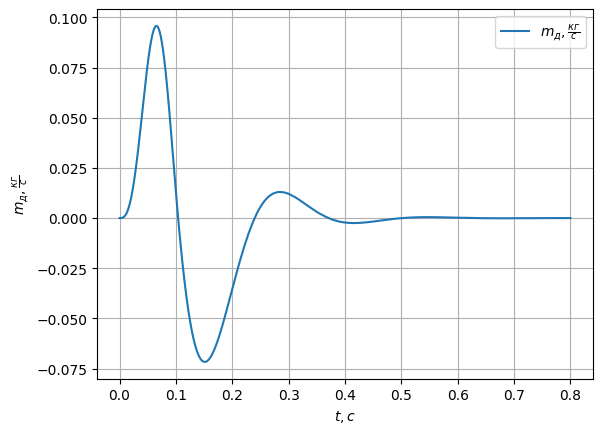

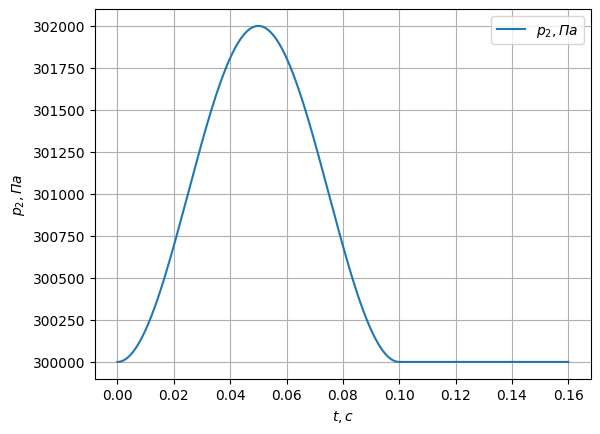

In [25]:
from matplotlib import pyplot as plt

def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("$t, с$")
    plt.ylabel(label)
    plt.legend()
    plt.show()


# plot(t[-100000:], sol[-100000:, 0], "p4")
plot(t[:len(sol[:, 0])], sol[:, 0], r"$p_4, Па$")
plot(t, pгаз, r"$p_{газ}, Па$")
plot(t, sol[:, 1], r"$V_д, м^3$")
# plot(t, sol[:, 2], r"$m_1, \frac{кг}{с}$")
# plot(t, sol[:, 3], r"$m_2, \frac{кг}{с}$")
# plot(t, sol[:, 4], r"$m_3, \frac{кг}{с}$")
plot(t[:len(sol[:, 0])], sol[:, 5], r"$m_д, \frac{кг}{с}$")
plot(t[:int(t_end//h//5)], [p2(t) for t in t][:int(t_end//h//5)], "$p_2, Па$")

### New

$$
\begin{cases}
\begin{align}
\frac{{d}}{{dt}}{p}_{4} &=\frac{\left(m_{1}+{m}_{2}-{m}_{3}-{m}_{\text{д}}\right)}{\frac{{V}_{\text{ж}0^{+}}{V}_{\text{д}}}{{c}^{2}}} \\

\frac{{d}}{{dt}}{V}_{д} &=\frac{m_{д}}{\rho_{ж}} \\

\frac{d}{dt}m_{д} &=\frac{\left[p_{4}-\frac{m_{газ}}{V_{г0}-V_{д}} \cdot R \cdot \left[T_{газ0} \cdot \left(\frac{p_{4}}{p_{4,0}}\right)^{\frac{k-1}{k}}\right]-\xi_{д} \cdot m_{д} \cdot \left|m_{д}\right|\right]}{j_{д}} \\

\frac{{d}}{{dt}}m_1 &=\frac{\left({p}_1-{p}_4-{\xi}_1\cdot{m}_1^2\right)}{{j}_1} \\

{\frac{d}{dt}}m_{2} &={\frac{\left(p_{2}-p_{4}-\xi_{2}\cdot m_{2}^{2}\right)}{j_{2}}} \\

\frac{d}{dt}m_{3} &=\frac{\left({p}_{4}-{p}_{3}-{\xi}_{3}\cdot{m}_{3}^{2}\right)}{{j}_{3}}
\end{align}
\end{cases}
$$

заметка к фото \
в 5 уравнении Vж0 = в p4 \
в 9 уравнении Vж это между пластинкой и газом \
в 6 уравнении Vж это обьем который клеблется между p4 и Vгаз т,е Vд

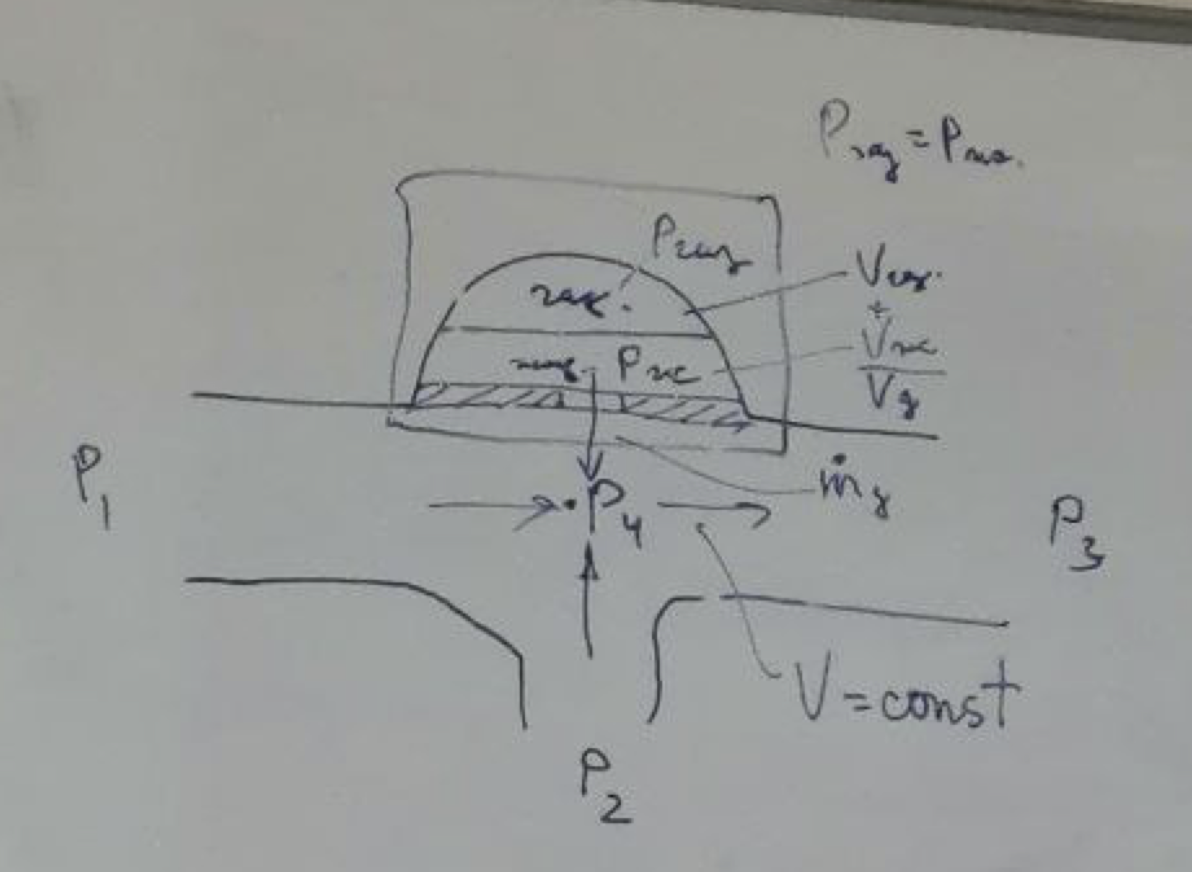
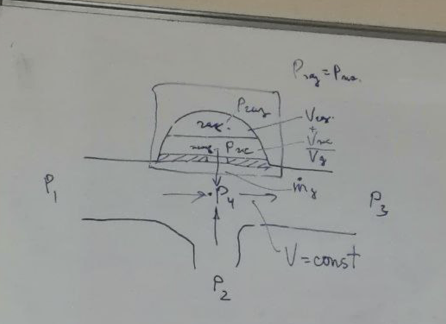

In [49]:
def system2(y, t):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y

    # ic(mд_sign(p4, mд, Vд))
    
    d_p4 = (m1 + m2 - m3 + mд_sign(p4, mд, Vд)) / ((Vж0) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * 
            (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


def mд_sign(p4, mд, Vд):

    pгаз = (mгаз / (Vг0 - Vд)) * R * \
            (Tгаз0 * ((p4 / p4_0)**((k-1)/k)))

    if p4 < pгаз:
        return mд
    # if p4 >= pгаз:
    return -mд


def p2_sin(t):
    """ Функция возмущения """
    z = 2 * t * pi/T
    insin = z - pi/2
    p2 = p2_0 + A*sin(insin)
    return p2


def p2(t):
    """ Функция возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


A = 1000
T = 0.1

t_end = 1
h = 1e-6

y0 = [p4_0, Vд_0, m1_0, m2_0, m3_0, mд_0]
t = np.arange(0, t_end, h)

# Решение
sol2 = odeint(system2, y0, t)

# Вывод таблицы значений
# ic(pd.DataFrame(data=sol, index=t))

pгаз2 = (mгаз / (Vг0 - sol2[:, 1])) * R * \
    (Tгаз0 * ((sol2[:, 0] / p4_0)**((k-1)/k)))

In [70]:
from scipy.integrate import solve_ivp


def system_4rk_new(t, y):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y
    
    return [(m1 + m2 - m3 - mд_sign(p4, mд, Vд)) / ((Vж0) / pow(c, 2)),
            mд / ρж,
            (p1 - p4 - ξ1 * m1 * abs(m1)) / j1,
            (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2,
            (p4 - p3 - ξ3 * m3 * abs(m3)) / j3,
            (p4 - (mгаз / (Vг0 + Vд)) * R * 
                (Tгаз0 * pow((p4 / p4_0), ((k-1)/k))) - 
                    ξд * mд * abs(mд)) / jд]


def p2(t):
    """ Функция возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


def mд_sign(p4, mд, Vд):

    pгаз = (mгаз / (Vг0 + Vд)) * R * \
            (Tгаз0 * pow((p4 / p4_0), ((k-1)/k)))

    if p4 < pгаз:
        return mд * -1
    # if p4 >= pгаз:
    return mд


A = 1000
T = 0.1

t_end = 1
h = 1e-5

y0 = [p4_0, Vд_0, m1_0, m2_0, m3_0, mд_0]

# Решение
sol_rk_new = solve_ivp(system_4rk_new, [0, t_end], y0, max_step=h)

# Таблица значений
sol_rk_df = pd.DataFrame(data=sol_rk_new.y.T, index=sol_rk_new.t.T)

# Вывод таблицы значений
# ic(sol_rk_df)

#### Построение графиков

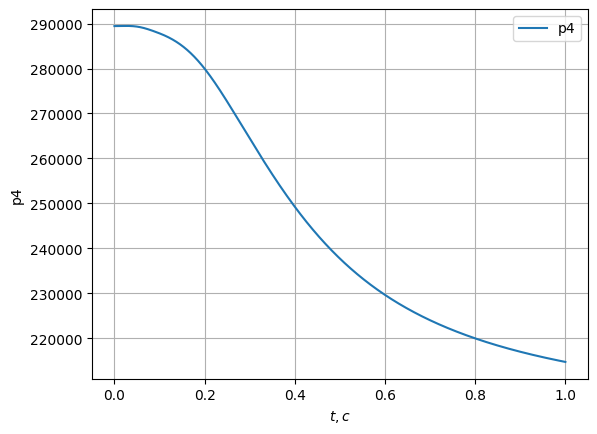

In [71]:
plot(sol_rk_new.t, sol_rk_new.y[0, :], "p4")

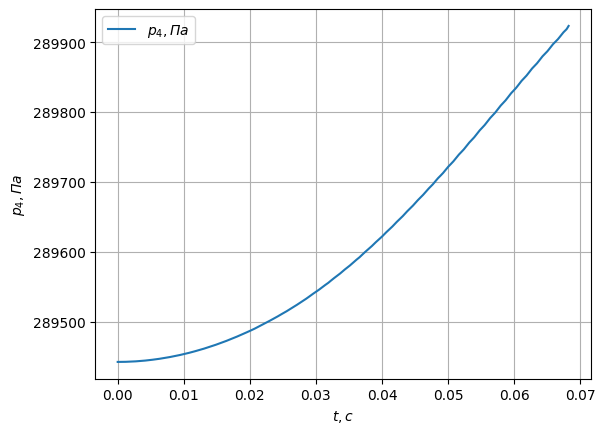

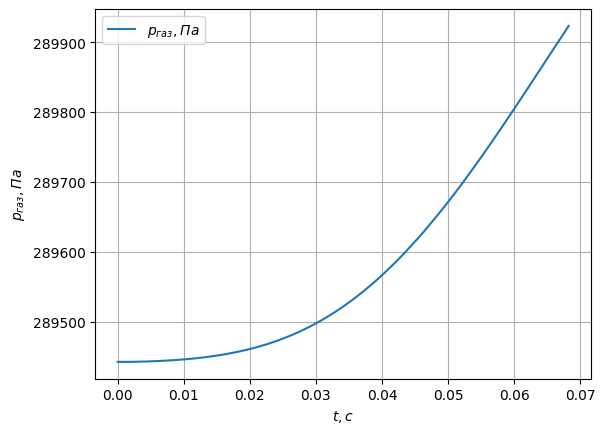

In [51]:
from matplotlib import pyplot as plt

def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("$t, с$")
    plt.ylabel(label)
    plt.legend()
    plt.show()


# plot(t[-100000:], sol[-100000:, 0], "p4")
plot(t[:len(sol2[:, 0])], sol2[:, 0], r"$p_4, Па$")
# plot(t, sol[:, 1], r"$V_д, м^3$")
# plot(t, sol[:, 2], r"$m_1, \frac{кг}{с}$")
# plot(t, sol[:, 3], r"$m_2, \frac{кг}{с}$")
# plot(t, sol[:, 4], r"$m_3, \frac{кг}{с}$")
# plot(t[:len(sol[:, 0])], sol[:, 5], r"$m_д, \frac{кг}{с}$")
plot(t[:len(sol2[:, 0])], pгаз2[:], r"$p_{газ}, Па$")
# plot(t[:int(t_end//h//5)], [p2_sin(t) for t in t][:int(t_end//h//5)], "$p_2, Па$")

## Решение динамической задачи без демпфера

### Решение СДУ

In [33]:
def system_no_damper(y, t):
    """ Система дифференциальных уравнений """
    p4, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3) / ((Vж0) / c**2)
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_m1, d_m2, d_m3]


def p2(t):
    """ Функция возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


t_end = .8
h = 1e-6
t = np.arange(0, t_end, h)

y0_n_d = [p4_0, m1_0, m2_0, m3_0]

sol_no_damper = odeint(system_no_damper, y0_n_d, t)

In [34]:
max(sol_no_damper[:, 0])

290457.69395877153

### Построение графиков

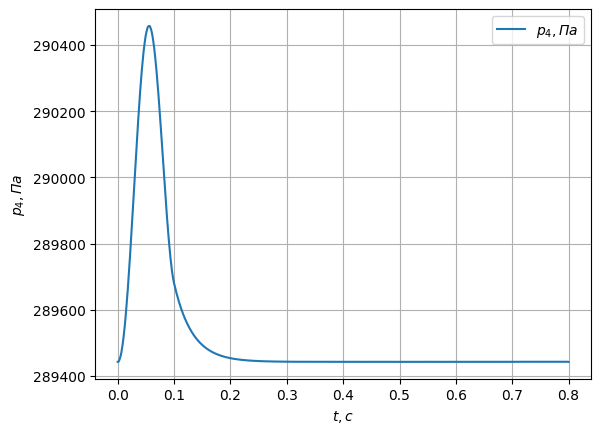

In [22]:
plot(t, sol_no_damper[:, 0], r"$p_4, Па$")
# plot(t, sol_no_damper[:, 1], r"$m_1, \frac{кг}{с}$")
# plot(t, sol_no_damper[:, 2], r"$m_2, \frac{кг}{с}$")
# plot(t, sol_no_damper[:, 3], r"$m_3, \frac{кг}{с}$")

## Построение АЧХ системы с демпфером

### Решение

$$
sin(f \cdot 2\pi t)
$$

In [68]:
def p2_sin_afc(t, freq):
    """ Функция возмущения, зависящая от частоты """
    # insin = freq * (t - 2*pi/4/freq)
    insin = freq * 2*pi * t 
    p2 = p2_0 + A*sin(insin)
    return p2


def system_afc(y, t, freq):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2_sin_afc(t, freq) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * 
            (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


frequancy = []
for freq in np.arange(0, 16, 1):
    frequancy.append(freq)
for freq in np.arange(20, 105, 5):
    frequancy.append(freq)
for freq in np.arange(125, 1025, 25):
    frequancy.append(freq)

sol_afc = []
for i, freq in enumerate(frequancy):
    sol_afc.append(odeint(system_afc, y0, t, (freq,)))

$$
AFC = \frac{\frac{max(p4) - min(p4)}{2}}{A}
$$

In [104]:
amplitude = []
for freq in range(len(frequancy)):
    amplitude.append(
        (max(sol_afc[freq][700000:800000, 0]) - 
         min(sol_afc[freq][700000:800000, 0])) / 2 / A) 
        
    
print(amplitude)

[2.6571797206997872e-11, 0.05601541950393585, 0.33615661094692767, 0.47545804604599834, 0.22081632087542674, 0.4018258503079705, 0.25198396314229465, 0.1633182269646495, 0.10504864771751454, 0.0643090265232313, 0.03689186896264437, 0.017696496235206725, 0.0038952975982974748, 0.009509073996625376, 0.017417723203427157, 0.023576478166301967, 0.04069983464528923, 0.04788556980728754, 0.05180182904945104, 0.05388993712433148, 0.05541798399426625, 0.0562696119764878, 0.05717045674129622, 0.05775169572830782, 0.05821636177285109, 0.05841967543427017, 0.05899566731628147, 0.05931310394269531, 0.05956293889746303, 0.059851858848793196, 0.05806722590589197, 0.06027133761282312, 0.06048151358490577, 0.06145614769100211, 0.06316153223469155, 0.06462994097641786, 0.06643229468434583, 0.06848975565415458, 0.07083501920953858, 0.0737802944976429, 0.07717610629709089, 0.08101859957777197, 0.08619227880760445, 0.09247256127864238, 0.10038440531029483, 0.11016255644607008, 0.1229565371319477, 0.140242

### Построение графиков

A(p4)/A то есть 1000

In [73]:
def plot_afc(freq):
    # fig, axs = plt.subplots(6, 1, figsize=(12, 60), dpi=300)
    fig, axs = plt.subplots(figsize=(12, 20), dpi=300)

    axs[0].plot(t, sol_afc[freq][:, 0], label=r"$p_4, Па$")
    # axs[1].plot(t, sol_afc[freq][:, 1], label=r"$V_д, м^3$")
    # axs[2].plot(t, sol_afc[freq][:, 2], label=r"$m_1, кг$")
    # axs[3].plot(t, sol_afc[freq][:, 3], label=r"$m_2, кг$")
    # axs[4].plot(t, sol_afc[freq][:, 4], label=r"$m_3, кг$")
    # axs[5].plot(t, sol_afc[freq][:, 5], label=r"$m_д, кг$")

    for ax in axs:
        ax.grid()
        ax.legend()

    plt.show()

#### Графики при $p_4(f)$

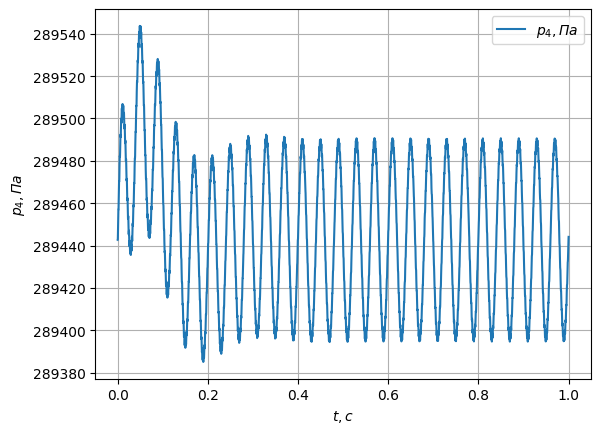

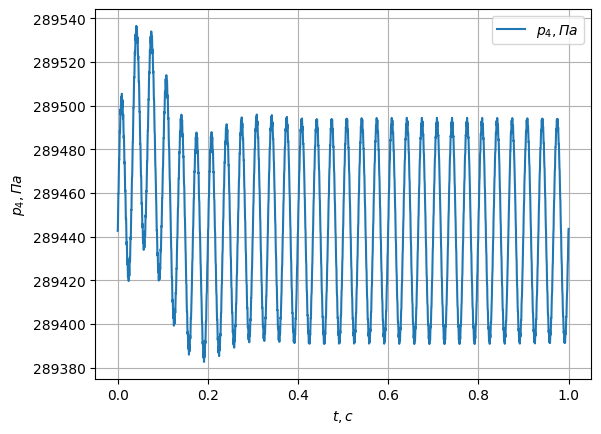

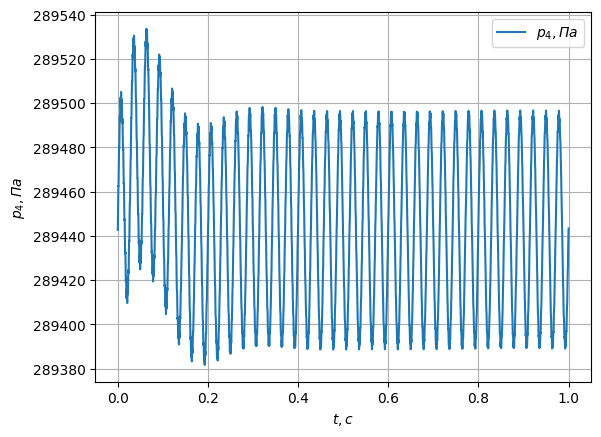

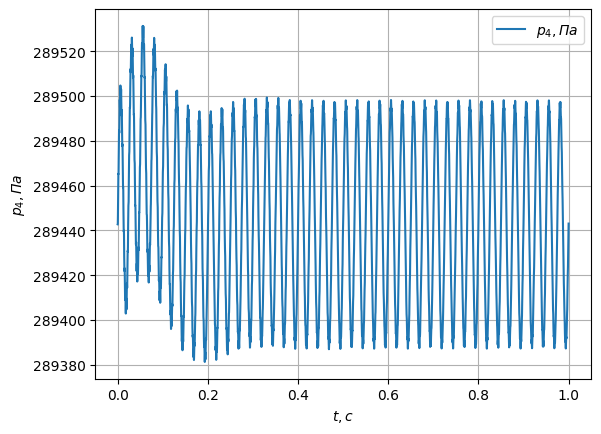

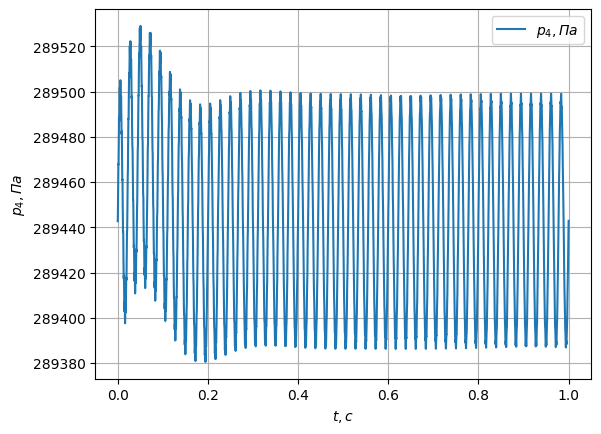

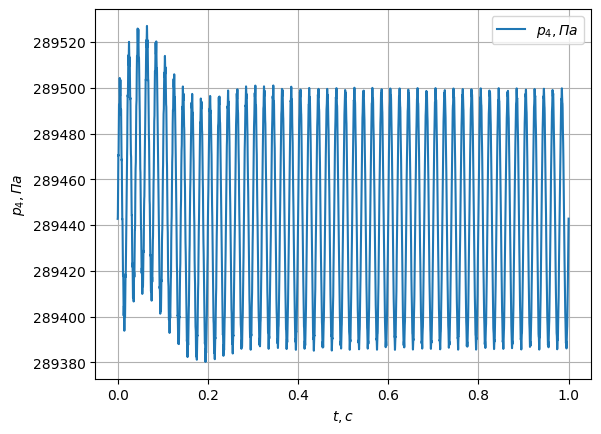

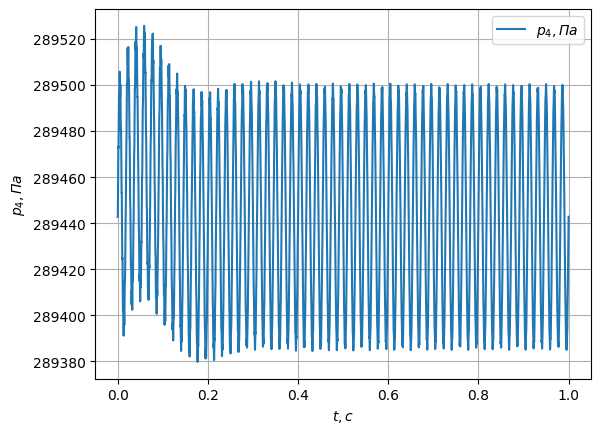

In [77]:
plot(t, sol_afc[17][:, 0], label=r"$p_4, Па$")
plot(t, sol_afc[18][:, 0], label=r"$p_4, Па$")
plot(t, sol_afc[19][:, 0], label=r"$p_4, Па$")
plot(t, sol_afc[20][:, 0], label=r"$p_4, Па$")
plot(t, sol_afc[21][:, 0], label=r"$p_4, Па$")
plot(t, sol_afc[22][:, 0], label=r"$p_4, Па$")
plot(t, sol_afc[23][:, 0], label=r"$p_4, Па$")

#### График АЧХ

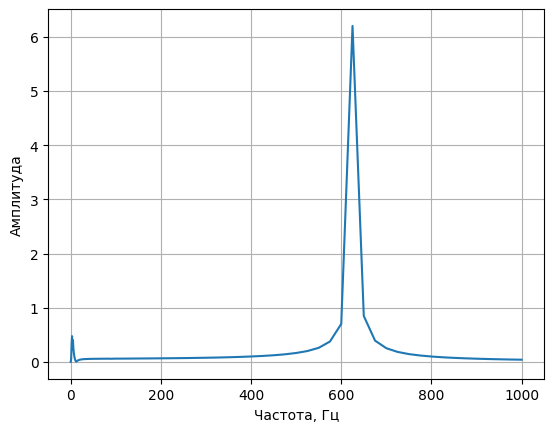

In [106]:
plt.plot(frequancy, amplitude)
plt.grid()
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.show()